## Question 2 - 4283724 Nadine Kanbier

### The query
Academia has long been a man's world. It is well documented that there are fewer women than men in tenured or tenure-track positions [1]. It is known as the 'Leaky Pipeline': a metaphor for women who opt-out of an academic career [2]. Researchers have approached the question of why women opt-out of this pipeline from multiple research perspectives, including sociological and psychological [3, 4, 5], but literature on the cultural perspective is lacking. 

As symbolic models, images have the potential to shape the perceptions of adolescent girls on gender roles and their own future roles [6]. They grow up in a media-rich environment filled with images that reinforce cultural norms of femininity and masculinity. Research has shown that the representation of female scientists in the media can show future generations of women that they belong [7]. 

By querying the word ‘Professor’ on Google Images, I want to find out what the representation of female professors in the media looks like. I will do this using a gender classifier on a Google image query of 50 'Professor' images.

In [9]:
# Import the needed packages
import os
import pandas as pd
import numpy as np

import cv2

import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image

import wget
from tqdm.notebook import tqdm

In [64]:
# Define load image from path.

%config InlineBackend.figure_format='retina' 

def load_image_from_path(image_path, target_size=None, color_mode='rgb'):
    pil_image = image.load_img(image_path, 
                               target_size=target_size,
                            color_mode=color_mode)
    return image.img_to_array(pil_image)

# Next, define the path and create the dataframe.

mypath = '/Users/nadinekanbier/Desktop/Applied Data Science/Periode 2/Data Mining/Exam 2/Images/'

image_paths = [image_path.path for image_path in os.scandir(mypath)] # the image paths
image_paths = [image for image in image_paths if image[-3:] in ['jpg', 'gif', 'epg', 'png']]


df = pd.DataFrame(image_paths) 
df.columns = ['File_path']
df.head()

,File_path
0,/Users/nadinekanbier/Desktop/Applied Data Scie...
1,/Users/nadinekanbier/Desktop/Applied Data Scie...
2,/Users/nadinekanbier/Desktop/Applied Data Scie...
3,/Users/nadinekanbier/Desktop/Applied Data Scie...
4,/Users/nadinekanbier/Desktop/Applied Data Scie...


In [65]:
# After creating the dataframe, we can now classify the faces and gender.

!wget https://github.com/oarriaga/face_classification/raw/master/trained_models/gender_models/gender_mini_XCEPTION.21-0.95.hdf5

model_url = 'https://github.com/oarriaga/face_classification/raw/master/trained_models/gender_models/gender_mini_XCEPTION.21-0.95.hdf5'
gender_model = wget.download(model_url)

from tensorflow.keras.models import load_model

def apply_offsets(face_coordinates, offsets):
    """
    Derived from https://github.com/oarriaga/face_classification/blob/
    b861d21b0e76ca5514cdeb5b56a689b7318584f4/src/utils/inference.py#L21
    """
    x, y, width, height = face_coordinates
    x_off, y_off = offsets
    return (x - x_off, x + width + x_off, y - y_off, y + height + y_off)

gender_classifier = load_model('gender_mini_XCEPTION.21-0.95.hdf5')

GENDER_OFFSETS = (10, 10)
INPUT_SHAPE_GENDER = gender_classifier.input_shape[1:3]

labels = ['woman', 'man']
n_female = []
n_male = []

# Face classification
for i in tqdm(range(0,len(df))):
    pre_image = load_image_from_path(df.File_path.values[i], color_mode='grayscale')
    gray_image = np.squeeze(pre_image).astype('uint8')

    face_classification = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') # load the classifier 
    faces = face_classification.detectMultiScale(gray_image, 1.3, 5) # detect the faces
    
    male = 0
    female = 0

# Gender classification
    for face_coordinates in faces: # using the output of the CascadeClassifier
        try:
            x1, x2, y1, y2 = apply_offsets(face_coordinates, GENDER_OFFSETS) # extends the bounding box
            face_img = gray_image[y1:y2, x1:x2] # only get the face 
            face_img = cv2.resize(face_img, (INPUT_SHAPE_GENDER)) # resize the image
            face_img = face_img.astype('float32') / 255.0 # preprocess the image
            face_img = np.expand_dims(face_img, 0) # batch of one
            probas = gender_classifier.predict(face_img)
        except:
            print('Error... Continuing')
            continue
            
        if labels[np.argmax(probas[0])] == 'man':
            male += 1
        elif labels[np.argmax(probas[0])] == 'woman':
            female += 1
    
    n_male.append(male)
    n_female.append(female)

/bin/bash: wget: command not found


Error... Continuing



In [66]:
df['n_male'] = n_male
df['n_female'] = n_female
df.head()

,File_path,n_male,n_female
0,/Users/nadinekanbier/Desktop/Applied Data Scie...,1,0
1,/Users/nadinekanbier/Desktop/Applied Data Scie...,0,0
2,/Users/nadinekanbier/Desktop/Applied Data Scie...,1,0
3,/Users/nadinekanbier/Desktop/Applied Data Scie...,1,0
4,/Users/nadinekanbier/Desktop/Applied Data Scie...,0,1


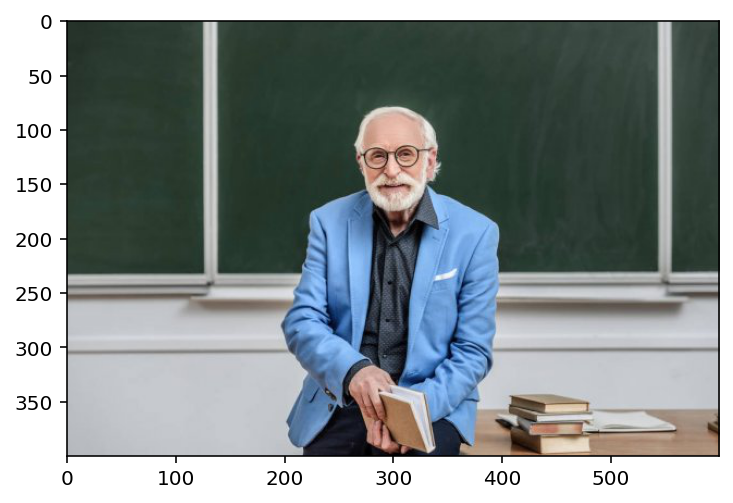

In [67]:
# Let's explore the results for a bit. Let's look at a male-labeled professor.
Image_male = df.File_path.values[2]
color_image_male = load_image_from_path(Image_male)

plt.imshow(color_image_male.astype(np.uint8))

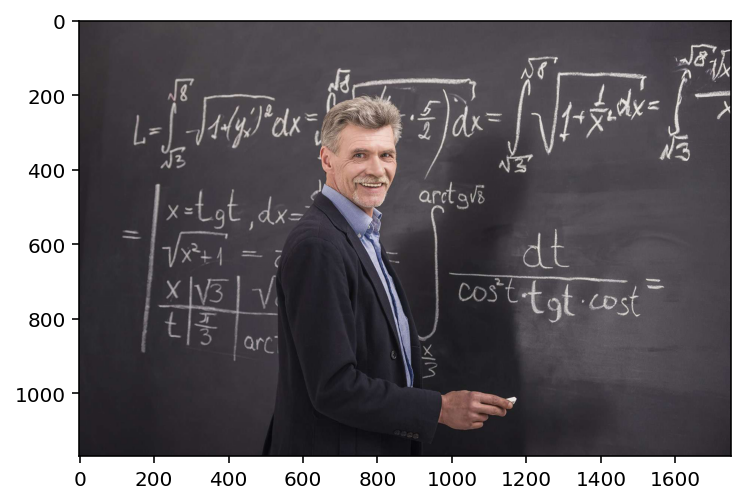

In [68]:
# Correctly labeled! Let's look at a female professor.
Image_female = df.File_path.values[4]
color_image_female = load_image_from_path(Image_female)

plt.imshow(color_image_female.astype(np.uint8))

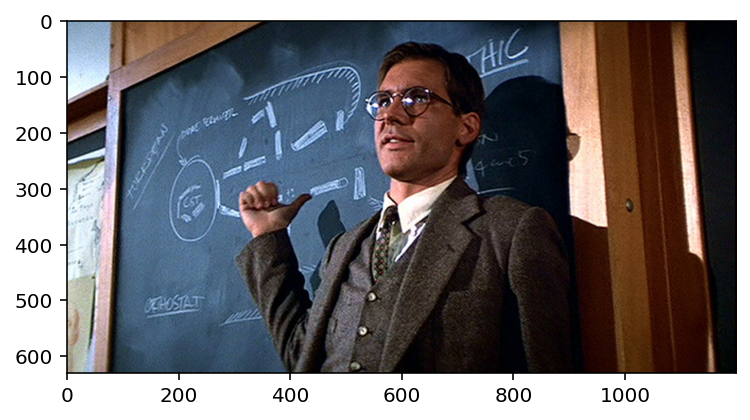

In [69]:
# Hmm, does not seem to work great for every case. Let's see what happens when there is no gender detected.
Image_non = df.File_path.values[1]
color_image_non = load_image_from_path(Image_non)

plt.imshow(color_image_non.astype(np.uint8))

In [37]:
# The gender detection model does not seem to work great. We need to be very careful when interpreting the results.
# But, for the sake of answering the question with this model, we will now look at the percentage of male and female
# professors in our query.

Total_males = df['n_male'].sum()
Total_females = df['n_female'].sum()
print(Total_males, Total_females)

25 13


In [62]:
# Percentage of male professors in our query
Total_males/(Total_males+Total_females) * 100

65.78947368421053

In [63]:
# Percentage of female professors in our query
Total_females/(Total_males+Total_females) * 100

34.21052631578947

### Conclusion and discussion
This analysis shows that the ‘Professor’ query on Google Images shows more male than female professors. In this small query, 66% of the images contain a male professor and 34% of the images contain a female professor. However, we need to be very careful interpreting these results, as we have seen that the classifier does not work properly all of the time. A larger query to reduce the measurement error. 

The results of this query show a larger proportion of male professors. According to the research centre Rathenau, the proportion of female professors in the Netherlands is currently 23%, with large differences in different faculties [1]. 

The analysis shows that there is a realistic representation of female professors in the media, but if we want to get the numbers up, we might have to look at the media as well as other previoulsy researched aspects. Although we cannot argument a causal relationship with this analysis, it is important for future research to take the cultural perspective into account when trying to fix the leaking pipeline. This analysis can be a stepping stone into the direction of further research into the cultural representation and its effect on maintaining the leaking pipeline. 

### References
1. https://www.rathenau.nl/en/science-figures/personnel/women-science/share-female-professors-netherlands-and-eu-countries
2. Berryman, S. E. (1983). Who Will Do Science? Trends, and Their Causes in Minority and Female Representation among Holders of Advanced Degrees in Science and Mathematics. A Special Report.
3. Van Anders, S. M. (2004). Why the academic pipeline leaks: Fewer men than women perceive barriers to becoming professors. Sex roles, 51(9-10), 511-521.
4. Wolfinger, N. H., Mason, M. A., & Goulden, M. (2008). Problems in the pipeline: Gender, marriage, and fertility in the ivory tower. The Journal of Higher Education, 79(4), 388-405.
5. Sheltzer, J. M., & Smith, J. C. (2014). Elite male faculty in the life sciences employ fewer women. Proceedings of the National Academy of Sciences, 111(28), 10107-10112.
6. Steinke, J., Lapinski, M., Long, M., Van Der Maas, C., Ryan, L., & Applegate, B. (2009). SEEING ONESELF AS A SCIENTIST: MEDIA INFLUENCES AND ADOLESCENT GIRLS'SCIENCE CAREER-POSSIBLE SELVES. Journal of Women and Minorities in Science and Engineering, 15(4).
7. Hart, M. (2018). Improved representation of female scientists in the media can show future generations of women that they belong. Impact of Social Sciences Blog.